In [1]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

# Source Image

Calculated PSF from PROPER

In [2]:
from spirals import binarized_ringed_flipped

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed_flipped(r, phi, phase)

beam_ratio = 0.4
toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }
gridsize = 2048 # sampling of wavefront
wavelength = 0.65 # micros

def get_source(dx, dy, dI):
    settings = toliman_settings.copy()
    settings['tilt_x'] = dx
    settings['tilt_y'] = dy
    new  = {
            'wavelengths': [wavelength],
            'weights': [dI],
            'settings': settings
            }
    return new

params_a = (-1,-0.5,1.3) # Chosen at random
params_b = (params_a[0],params_a[1]+5.,params_a[2]/3.)

In [3]:
import proper
detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

# Calculated PSF
# First source, on axis
# Second source, offset 5" and fainter
from proper_tools import form_detector_image
raw_image = form_detector_image('prescription_rc_quad', [get_source(params_a[0],params_a[1],params_a[2]), get_source(params_b[0],params_b[1],params_b[2])], gridsize, detector_pitch, npixels)

/suphys/bjef8061/.local/lib/python3.5/site-packages/pyfits-3.5-py3.5-linux-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [4]:
import numpy as np
src_peak_photons = 25000
src_intensity_scale = (src_peak_photons/raw_image.max(axis=None))
raw_image = np.clip(src_intensity_scale*raw_image,0.,None)
detector_image = np.random.poisson(raw_image)

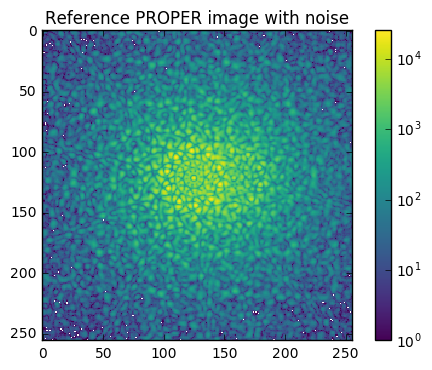

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.imshow(detector_image[128:128*3,128:128*3], interpolation = 'none', cmap='viridis',norm=LogNorm())
plt.colorbar()
plt.title('Reference PROPER image with noise')
plt.show()

# Fitting

## Create a dual PSF and check fitting error


In [6]:
# Calculated PSF using on-axis image
from proper_tools import form_detector_image, form_multi_psf, fix_prop_pixellate

In [7]:
test_flux = 1.0
print('Flux based upon observed peak = {}'.format(test_flux))
test_offset = (0.,0.)
print('Test PSF centred at ({},{})'.format(test_offset[0],test_offset[1]))
      
common_sampling = detector_pitch/2. # for Nyquist
npsf = npixels*2
print('Generating PSF with sampling {} and size {}'.format(common_sampling,npsf))
psf_ref = form_multi_psf('prescription_rc_quad', [get_source(test_offset[0],test_offset[1],test_flux)], gridsize, common_sampling, npsf)


Flux based upon observed peak = 1.0
Test PSF centred at (0.0,0.0)
Generating PSF with sampling 5.5e-06 and size 1024


In [8]:
f_eff = 15. # metres
as_to_m = f_eff * np.pi / (3600 * 180) #m/as

model = {}
model['x'] = [0.,0.,0.,0.,0.,0.]
model['psf_a_pix'] = np.zeros_like(detector_image)
model['psf_b_pix'] = np.zeros_like(detector_image)

def model_image():
    return (model['psf_a_pix']*model['x'][2] + model['psf_b_pix']*model['x'][5]) * src_intensity_scale

def set_psf_a(im):
    model['psf_a_pix'] = im

def image_err(im):
    diff = im - detector_image
    return np.sum((diff)**2)
    
min_err = image_err(raw_image)
print('Minimum error (original - noisy) = {}'.format(min_err))

Minimum error (original - noisy) = 25570108.47422106


In [9]:
def update_err(printerr=False):
    x = model['x']
    tiltx1 = x[0]
    tilty1 = x[1]    
    flux1 = x[2]
    tiltx2 = x[3]
    tilty2 = x[4]
    flux2 = x[5]
    err = image_err(model_image())
    errors.append((x.copy(),err))
    if printerr is True:
        print('Error for offsets ({:.2e},{:.2e}),({:.2e},{:.2e}) and fluxes {:.2e},{:.2e}: {}% baseline '.format(tiltx1, tiltx1, tiltx2, tiltx2, flux1, flux2, round(100.*err/min_err)))
    return err

def set_pos_a(dx,dy):
    x = model['x']
    x[0] = dx
    x[1] = dy
    set_psf_a(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(dx*as_to_m,dy*as_to_m)))

def model_err_major_pos(params, printerr=False):
    set_pos_a(params[0],params[1])
    return update_err(printerr)


In [10]:
def set_psf_b(im):
    model['psf_b_pix'] = im
    
def set_pos_b(dx,dy):
    x = model['x']
    x[3] = dx
    x[4] = dy
    set_psf_b(fix_prop_pixellate(psf_ref, common_sampling, detector_pitch, n_out = npixels, offset=(dx*as_to_m,dy*as_to_m)))

def model_err_minor_pos(params, printerr=False):
    set_pos_b(params[0],params[1])
    return update_err(printerr)


## Step 1: major source position

In [11]:
model['x'] = [0.,0.,0.,0.,0.,0.]
est_flux = detector_image.max(axis=None)*1. / src_peak_photons
model['x'][2] = est_flux
print(model['x'])

[0.0, 0.0, 1.0061599999999999, 0.0, 0.0, 0.0]


In [12]:
import numpy as np
errors = []
ds = np.linspace(-10, 10, 11)
for dx in ds:
    for dy in ds:
        model_err_major_pos([dx,dy], printerr=False)

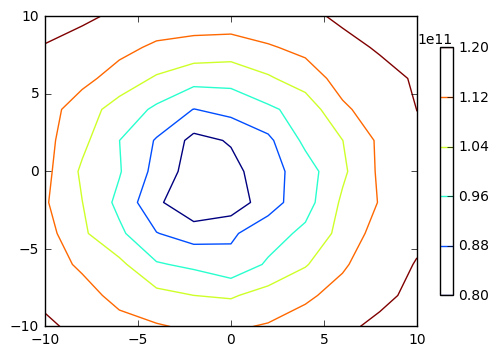

In [13]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X,Y  = np.meshgrid(ds,ds)
plt.figure()
Z = np.reshape([e for ((dx1,dy1,df1,dx2,dy2,df2),e) in errors],(len(ds),len(ds)), order='F')
CS = plt.contour(X, -Y, Z)
plt.colorbar(CS, shrink=0.8, extend='both')
plt.show()

In [14]:
import numpy as np
ds = np.linspace(-2.5, 2.5, 11)
for dx in ds:
    for dy in ds:
        model_err_major_pos([dx,dy], printerr=False)

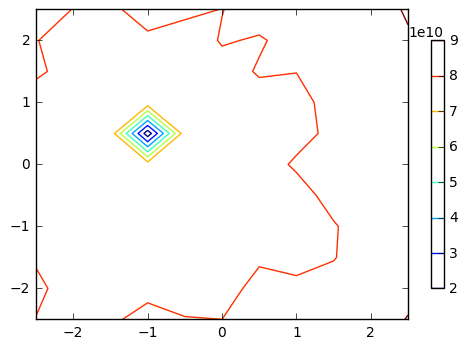

In [15]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X,Y  = np.meshgrid(ds,ds)
plt.figure()
Z = np.reshape([e for ((dx1,dy1,df1,dx2,dy2,df2),e) in errors[-len(ds)**2:]],(len(ds),len(ds)), order='F')
CS = plt.contour(X, -Y, Z)
plt.colorbar(CS, shrink=0.8, extend='both')
plt.show()

In [16]:
def get_xmin(errs):
    xmin = errs[0][0]
    emin = errs[0][1]
    for (x,e) in errs[1:]:
        if e<emin:
            emin = e
            xmin = x
    return xmin

In [17]:
from scipy.optimize import minimize

xmin = get_xmin(errors[-len(ds)**2:])
print(xmin)
delta=2. # stepping of above exploration
opt = minimize(model_err_major_pos, [xmin[0], xmin[1]], method='L-BFGS-B',
               bounds=[(xmin[0]-delta,xmin[0]+delta),
                       (xmin[1]-delta,xmin[1]+delta)
                      ])
print(opt)

[-1.0, -0.5, 1.0061599999999999, 0.0, 0.0, 0.0]
      fun: 13707032384.254185
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([   0.        ,  572.20458984])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 3
   status: 0
  success: True
        x: array([-0.99928227, -0.49572659])


In [18]:
ds = np.linspace(-2, 2, 5)
for dx in ds:
    for dy in ds:
        model_err_major_pos([xmin[0]+dx,xmin[1]+dy], printerr=False)

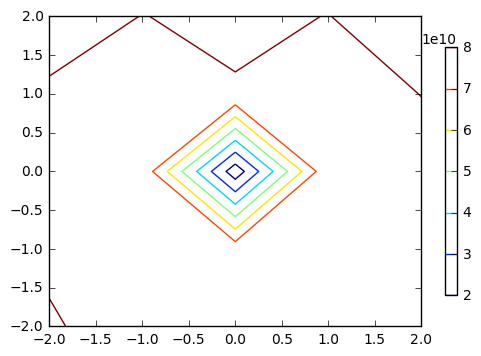

In [19]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X,Y  = np.meshgrid(ds,ds)
plt.figure()
Z = np.reshape([e for ((dx1,dy1,df1,dx2,dy2,df2),e) in errors[-len(ds)**2:]],(len(ds),len(ds)), order='F')
CS = plt.contour(X, -Y, Z)
plt.colorbar(CS, shrink=0.8, extend='both')
plt.show()

In [20]:
xmin = get_xmin(errors[-len(ds)**2:])

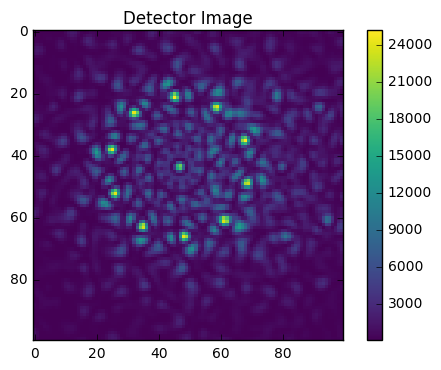

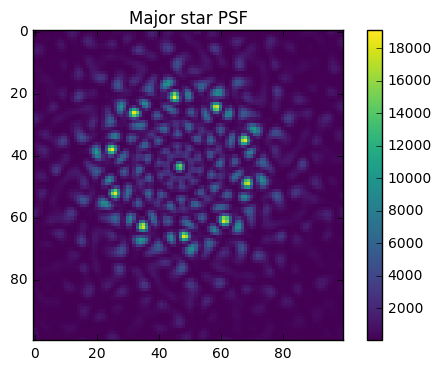

In [21]:
set_pos_a(xmin[0],xmin[1])
plt.imshow(detector_image[256-50:256+50,256-50:256+50], interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.title('Detector Image')
plt.show()
plt.imshow((model_image())[256-50:256+50,256-50:256+50], interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.title('Major star PSF')
plt.show()

In [22]:
from scipy.optimize import minimize

delta=1. # stepping of above exploration
opt = minimize(model_err_major_pos, [xmin[0], xmin[1]], method='L-BFGS-B',
               bounds=[(xmin[0]-delta,xmin[0]+delta),
                       (xmin[1]-delta,xmin[1]+delta)
                      ])
print(opt)

      fun: 13707032384.254187
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-381.46972656,    0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 3
   status: 0
  success: True
        x: array([-0.99928227, -0.49572659])


In [23]:
xmin = opt.x
set_pos_a(xmin[0],xmin[1])

##  Step 2: major source flux

In [24]:
def set_major_flux(f):
    x = model['x']
    x[2] = f

def model_err_major_flux(f, printerr=False):
    set_major_flux(f)
    return update_err(printerr)

In [25]:
def set_minor_flux(f):
    x = model['x']
    x[5] = f
    
def model_err_minor_flux(f, printerr=False):
    set_minor_flux(f)
    return update_err(printerr)

In [26]:
from scipy.optimize import minimize_scalar

opt = minimize_scalar(model_err_major_flux, model['x'][3], method='bounded',
               bounds=(0,2.))
print(opt)
xmin = opt.x
set_major_flux(xmin)

     fun: 7009224772.4558458
 message: 'Solution found.'
    nfev: 6
  status: 0
 success: True
       x: 1.4147433507771636


## Step 3: minor source position

In [27]:
#residual = np.clip(detector_image - get_tilted_image(opt.x[0],opt.x[1],opt.x[2]),0,None)
residual = detector_image - model_image()

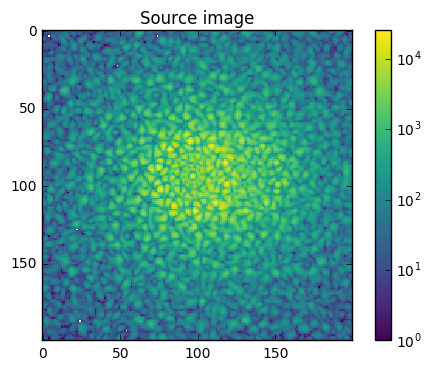

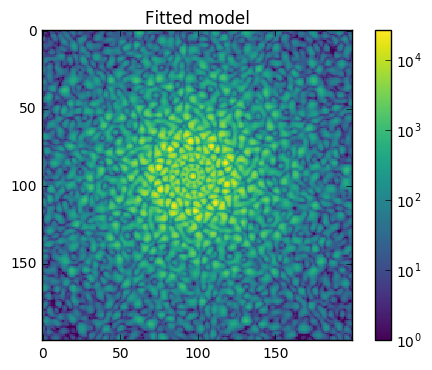

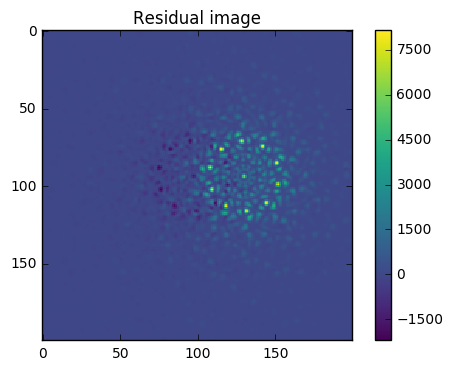

In [28]:
plt.imshow(detector_image[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Source image')
plt.show()

plt.imshow(model_image()[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Fitted model')
plt.show()

plt.imshow(residual[256-100:256+100,256-100:256+100], interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.title('Residual image')
plt.show()

In [29]:
est_flux = residual.max(axis=None)*1. / src_peak_photons
print('Flux based upon observed peak = {}'.format(est_flux))
set_minor_flux(est_flux)

Flux based upon observed peak = 0.32615286562367657


In [41]:
import numpy as np
ds = np.linspace(-10, 10, 11)
for dx in ds:
    for dy in ds:
        model_err_minor_pos([dx,dy], printerr=False)

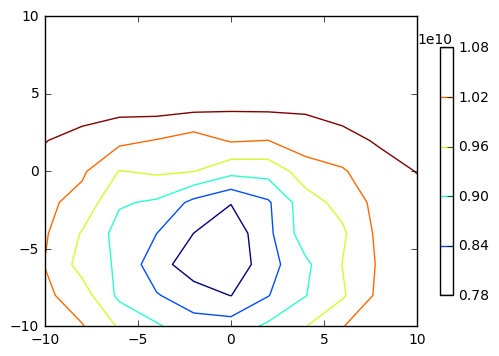

In [42]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X,Y  = np.meshgrid(ds,ds)
plt.figure()
Z = np.reshape([e for ((dx1,dy1,df1,dx2,dy2,df2),e) in errors[-len(ds)**2:]],(len(ds),len(ds)), order='F')
CS = plt.contour(X, -Y, Z)
plt.colorbar(CS, shrink=0.8, extend='both')
plt.show()

In [43]:
from scipy.optimize import minimize

xmin = get_xmin(errors[-len(ds)**2:])
print(xmin)
(dx,dy) = (xmin[3], xmin[4])
delta=2. # stepping of above exploration
opt = minimize(model_err_minor_pos, [dx,dy], method='L-BFGS-B',
               bounds=[(dx-delta,dx+delta),
                       (dy-delta,dy+delta)
                      ])
print(opt)

[-0.99928227486444365, -0.49572659207105918, 1.4147433507771636, 0.0, 6.0, 0.32615286562367657]
      fun: 7064076686.0085917
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-476.8371582 , -286.10229492])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 11
   status: 0
  success: True
        x: array([-0.56039102,  5.87727627])


In [44]:
xmin=opt.x
ds = np.linspace(-4, 4, 11)
for dx in ds:
    for dy in ds:
        model_err_minor_pos([xmin[0]+dx,xmin[1]+dy], printerr=False)

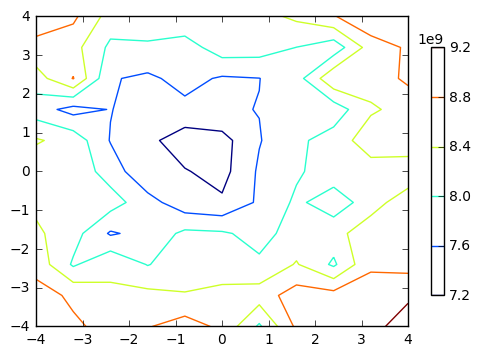

In [45]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X,Y  = np.meshgrid(ds,ds)
plt.figure()
Z = np.reshape([e for ((dx1,dy1,df1,dx2,dy2,df2),e) in errors[-len(ds)**2:]],(len(ds),len(ds)), order='F')
CS = plt.contour(X, -Y, Z)
plt.colorbar(CS, shrink=0.8, extend='both')
plt.show()

In [46]:
from scipy.optimize import minimize

xmin = get_xmin(errors[-len(ds)**2:])
print(xmin)
(dx,dy) = (xmin[3], xmin[4])
delta=.5 # stepping of above exploration
opt = minimize(model_err_minor_pos, [dx,dy], method='L-BFGS-B',
               bounds=[(dx-delta,dx+delta),
                       (dy-delta,dy+delta)
                      ])
print(opt)

[-0.99928227486444365, -0.49572659207105918, 1.4147433507771636, -1.3603910235467982, 5.0772762687509765, 0.32615286562367657]
      fun: 6964161604.3348541
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 95.36743164,   0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 6
   status: 0
  success: True
        x: array([-1.30807205,  5.12900653])


In [47]:
xmin = opt.x
set_pos_b(xmin[0],xmin[1])

## Step 4: minor source flux

In [48]:
from scipy.optimize import minimize_scalar

opt = minimize_scalar(model_err_minor_flux, model['x'][5], method='bounded',
               bounds=(0,2.))
print(opt)
xmin = opt.x
set_minor_flux(xmin)

     fun: 5919597226.7075977
 message: 'Solution found.'
    nfev: 6
  status: 0
 success: True
       x: 0.16479829294456133


In [49]:
#set_minor_flux(0.3271041000515373)

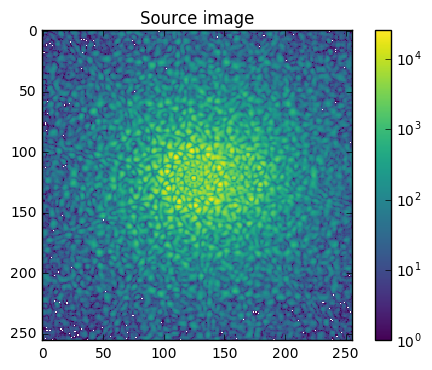

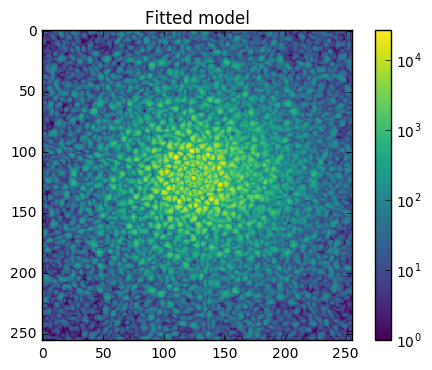

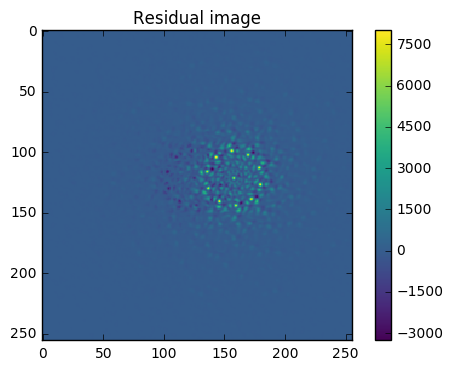

In [50]:
residual = detector_image - model_image()
plt.imshow(detector_image[128:128*3,128:128*3], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Source image')
plt.show()

plt.imshow(model_image()[128:128*3,128:128*3], interpolation = 'none', cmap='viridis',norm=LogNorm(),vmin=1.)
plt.colorbar()
plt.title('Fitted model')
plt.show()

plt.imshow(residual[128:128*3,128:128*3], interpolation = 'none', cmap='viridis')
plt.colorbar()
plt.title('Residual image')
plt.show()

# Convergence summary

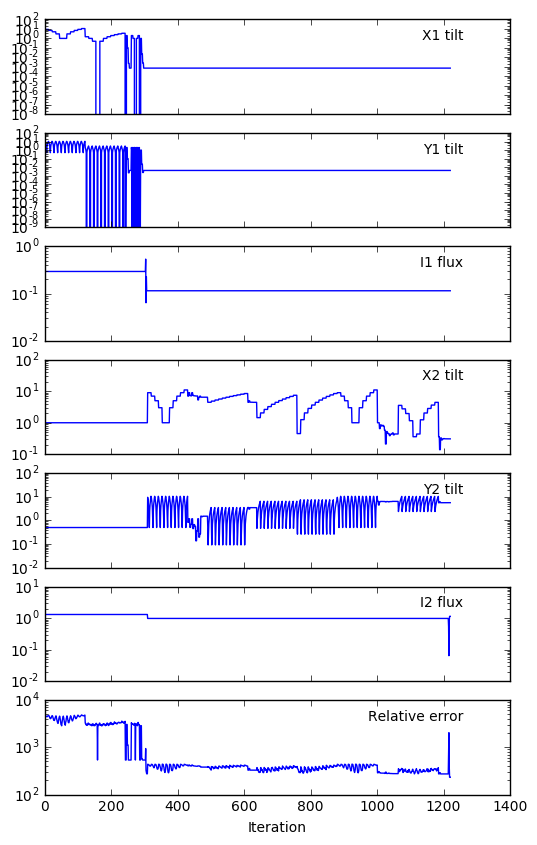

In [52]:
#Visualise the space explored by the optimiser
import matplotlib.pyplot as plt
import math

(I,X1,Y1,F1,X2,Y2,F2,E) = zip(*[(i,dx1-params_a[0],dy1-params_a[1],df1 - params_a[2],
                                 dx2-params_b[0],dy2-params_a[1],df2 - params_a[2],e/min_err) for i,((dx1,dy1,df1,dx2,dy2,df2),e) in enumerate(errors)])

f, axes = plt.subplots(7, sharex=True,figsize=(6,10))
labels = ['X1 tilt','Y1 tilt','I1 flux','X2 tilt','Y2 tilt','I2 flux','Relative error']
for i,V in enumerate([X1,Y1,F1,X2,Y2,F2,E]):
    axes[i].plot(I, np.abs(V))
    axes[i].text(.9,.9,labels[i],
            horizontalalignment='right', verticalalignment='top',
            transform=axes[i].transAxes)
    axes[i].locator_params(axis='y', nbins=6)
    axes[i].set_yscale('log')
axes[6].set_xlabel('Iteration')
plt.show()

At this point the optimiser could be re-run to perform some annealing around the local area. 